In [11]:
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
tf.get_logger().setLevel("ERROR")


# Charger le CSV
df = pd.read_csv("../data/dataset_selection_non_zoomer.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


Aperçu du dataset :
                                                path     label
0  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
1  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
2  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
3  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
4  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    6046 non-null   object
 1   label   6046 non-null   object
dtypes: object(2)
memory usage: 94.6+ KB
None


In [12]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 6046
Nombre de colonnes : 2


In [13]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
mda         1552
glaucome    1500
diabete     1500
normaux     1494
Name: count, dtype: int64

Pourcentage par label :
label
mda         25.67
glaucome    24.81
diabete     24.81
normaux     24.71
Name: proportion, dtype: float64


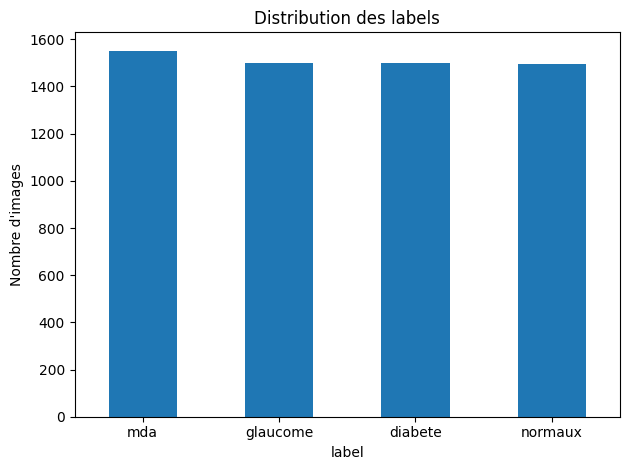

In [14]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [15]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/1906.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/2695.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/0544.jpg']

Exemples pour la classe 'mda' :
['/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/161.png', '/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/328.png', '/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/235.png']

Exemples pour la classe 'diabete' :
['/home/mathis/Memoire/data/diabete/train.zip/train/27895_right.jpeg', '/home/mathis/Memoire/data/diabete/train.zip/train/36728_left.jpeg', '/home/mathis/Memoire/data/diabete/train.zip/train/31549_left.jpeg']

Exemples pour la classe 'normaux' :
['/home/mathis/Memoire/data/mda/ODIR-5K/ODIR-5K/Training Images/2661_left.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/normal/1940.jpg', '/home/mathis/Memoire/data/mda/fundus-dataset/00. Normal/img_0291.jpg']


In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")
print(f"Validation : {len(df_val)}")

Tailles des splits :
Train : 4232
Test : 907
Validation : 907


In [17]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)
show_distribution("Validation", df_val)



Train
label
mda         0.257
diabete     0.248
glaucome    0.248
normaux     0.247
Name: proportion, dtype: float64

Test
label
mda         0.257
glaucome    0.248
diabete     0.248
normaux     0.247
Name: proportion, dtype: float64

Validation
label
mda         0.257
diabete     0.248
glaucome    0.248
normaux     0.247
Name: proportion, dtype: float64


In [18]:
import sys, torch
print(sys.executable)
print(torch.__version__)
import torch
print(torch.__version__)
print("cuda available:", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

x = torch.randn(1000, 1000, device="cuda")
print("OK:", x.mean().item())


/home/mathis/Memoire/.venv/bin/python
2.5.1+cu121
2.5.1+cu121
cuda available: True
NVIDIA GeForce RTX 3070 Ti
OK: 0.0010178493103012443


In [22]:
# =========================
# PyTorch pipeline COMPLET (ResNet34 pré-entraîné + class weights + AMP + AdamW + ReduceLROnPlateau + EarlyStopping)
# =========================

import os, numpy as np
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

IMG = 224
BATCH = 32
EPOCHS = 300
PATIENCE = 20
NUM_WORKERS = 2

# -------------------------------------------------
# 0) Device
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------
# 1) Transforms (ImageNet)
# -------------------------------------------------
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize(IMG+32),
    transforms.CenterCrop(IMG),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# -------------------------------------------------
# 2) Dataset depuis DataFrame splits: df_train/df_val/df_test
#    df_* doit contenir colonnes: "path" et "label"
# -------------------------------------------------
class FromSamples(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.array(paths)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, int(self.labels[i])

# --- Vérif colonnes ---
for name, d in [("df_train", df_train), ("df_val", df_val), ("df_test", df_test)]:
    assert "path" in d.columns and "label" in d.columns, f"{name} doit avoir colonnes 'path' et 'label'"

# --- Remap labels -> {0..C-1} (IMPORTANT pour CrossEntropyLoss) ---
orig_classes = sorted(df_train["label"].unique().tolist())
label_map = {c: i for i, c in enumerate(orig_classes)}
print("Label mapping:", label_map)

df_train = df_train.copy()
df_val   = df_val.copy()
df_test  = df_test.copy()

df_train["label"] = df_train["label"].map(label_map)
df_val["label"]   = df_val["label"].map(label_map)
df_test["label"]  = df_test["label"].map(label_map)

# --- Datasets ---
ds_train = FromSamples(df_train["path"].values, df_train["label"].values, train_tfms)
ds_val   = FromSamples(df_val["path"].values,   df_val["label"].values,   eval_tfms)
ds_test  = FromSamples(df_test["path"].values,  df_test["label"].values,  eval_tfms)

train_loader = DataLoader(ds_train, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------------------------------------
# 3) Class weights (robuste, sans division par zéro)
# -------------------------------------------------
cnt = Counter(df_train["label"].values.tolist())
num_classes = len(orig_classes)

print("Train counts:", cnt)
if len(cnt) != num_classes:
    print("⚠️ Attention: une ou plusieurs classes sont absentes du train. "
          "Impossible de calculer des poids pour une classe absente. "
          "On calcule quand même des poids, mais ton split est à revoir.")

# On construit un vecteur de taille num_classes, avec fallback si cnt[c]==0
weights_list = []
for c in range(num_classes):
    if cnt.get(c, 0) == 0:
        # fallback: poids = 1.0 (tu peux aussi mettre très grand, mais ça casse souvent l'entraînement)
        weights_list.append(1.0)
    else:
        weights_list.append(len(df_train) / (num_classes * cnt[c]))

weights_ce = torch.tensor(weights_list, dtype=torch.float32, device=device)
print("Class weights:", weights_ce.tolist())

# -------------------------------------------------
# 4) Modèle: ResNet34 pré-entraîné ImageNet + tête 2 classes (ou num_classes)
# -------------------------------------------------
weights = models.ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights_ce)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
scaler = GradScaler()

# -------------------------------------------------
# 5) Eval / Train loops + Early stopping
# -------------------------------------------------
@torch.no_grad()
def evaluate(loader):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        n += x.size(0)
    return loss_sum / max(n, 1), correct / max(n, 1)

best_acc, best_state = 0.0, None
wait = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    run_loss, n = 0.0, 0

    for x, y in train_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item() * x.size(0)
        n += x.size(0)

    train_loss = run_loss / max(n, 1)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f} | lr {optimizer.param_groups[0]['lr']:.6f}")

    if val_acc > best_acc:
        best_acc = val_acc
        wait = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break


Device: cuda
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Train counts: Counter({2: 1086, 0: 1050, 1: 1050, 3: 1046})
Class weights: [1.007619023323059, 1.007619023323059, 0.9742172956466675, 1.011472225189209]


/home/mathis/Memoire/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_1319/2858140584.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1319/2858140584.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_1319/2858140584.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001 | train_loss 0.6592 | val_loss 0.8725 | val_acc 0.6692 | lr 0.000100
Epoch 002 | train_loss 0.5062 | val_loss 0.9166 | val_acc 0.6759 | lr 0.000100
Epoch 003 | train_loss 0.4394 | val_loss 0.8465 | val_acc 0.6781 | lr 0.000100
Epoch 004 | train_loss 0.4018 | val_loss 0.7645 | val_acc 0.7211 | lr 0.000100
Epoch 005 | train_loss 0.3732 | val_loss 1.0892 | val_acc 0.6681 | lr 0.000100
Epoch 006 | train_loss 0.3535 | val_loss 0.6213 | val_acc 0.7233 | lr 0.000100
Epoch 007 | train_loss 0.3297 | val_loss 0.6151 | val_acc 0.7486 | lr 0.000100
Epoch 008 | train_loss 0.3047 | val_loss 0.9608 | val_acc 0.6935 | lr 0.000100
Epoch 009 | train_loss 0.2855 | val_loss 0.8821 | val_acc 0.7200 | lr 0.000100
Epoch 010 | train_loss 0.2674 | val_loss 0.9638 | val_acc 0.6968 | lr 0.000100
Epoch 011 | train_loss 0.2693 | val_loss 0.8947 | val_acc 0.7067 | lr 0.000100
Epoch 012 | train_loss 0.2345 | val_loss 0.8383 | val_acc 0.7563 | lr 0.000100
Epoch 013 | train_loss 0.2316 | val_loss 0.8331 | va


=== Scores globaux ===
Accuracy            : 0.7585
Balanced accuracy   : 0.7576
Precision (macro)   : 0.7828
Recall (macro)      : 0.7576
F1 (macro)          : 0.7464
Precision (weighted): 0.7839
Recall (weighted)   : 0.7585
F1 (weighted)       : 0.7476

=== Rapport par classe ===
              precision    recall  f1-score   support

           0       0.88      0.44      0.59       225
           1       0.76      0.97      0.85       225
           2       0.88      0.87      0.87       233
           3       0.61      0.75      0.67       224

    accuracy                           0.76       907
   macro avg       0.78      0.76      0.75       907
weighted avg       0.78      0.76      0.75       907



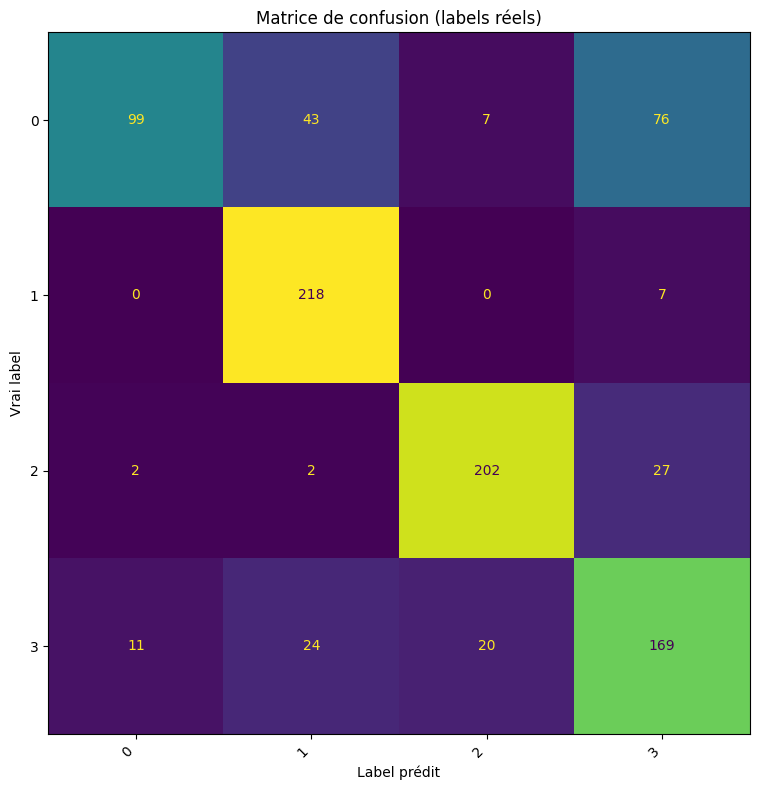

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)

model.eval()
all_y, all_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_pred.append(preds)
        all_y.append(y.numpy())

y_true = np.concatenate(all_y, axis=0)
y_pred = np.concatenate(all_pred, axis=0)

classes = orig_classes
num_classes = len(classes)

# ----------------------------
# 7) METRICS
# ----------------------------
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("\n=== Scores globaux ===")
print(f"Accuracy            : {acc:.4f}")
print(f"Balanced accuracy   : {bacc:.4f}")
print(f"Precision (macro)   : {prec_macro:.4f}")
print(f"Recall (macro)      : {rec_macro:.4f}")
print(f"F1 (macro)          : {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted)   : {rec_weighted:.4f}")
print(f"F1 (weighted)       : {f1_weighted:.4f}")

print("\n=== Rapport par classe ===")
target_names = [str(c) for c in classes]
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# ----------------------------
# 8) CONFUSION MATRIX (labels réels, ordre forcé)
# ----------------------------
label_indices = list(range(num_classes))
cm = confusion_matrix(y_true, y_pred, labels=label_indices)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax, values_format="d", cmap=None, colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Label prédit")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion (labels réels)")
plt.tight_layout()
plt.show()


Nombre d'images mal classées : 219


I0000 00:00:1768952498.851388    1319 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3951 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


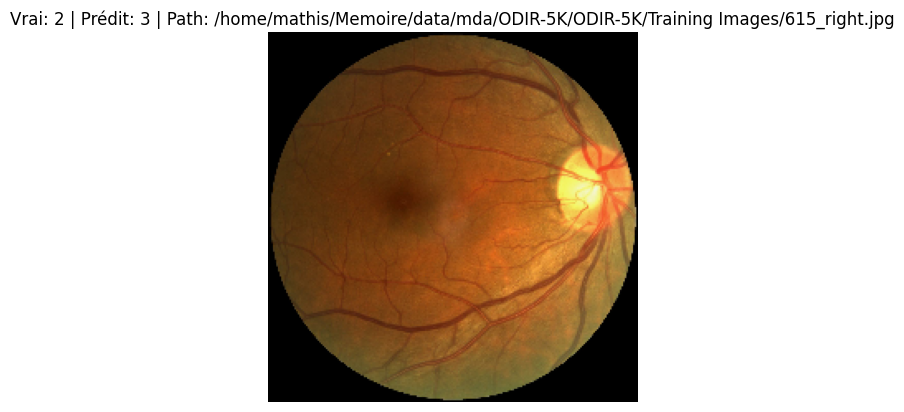

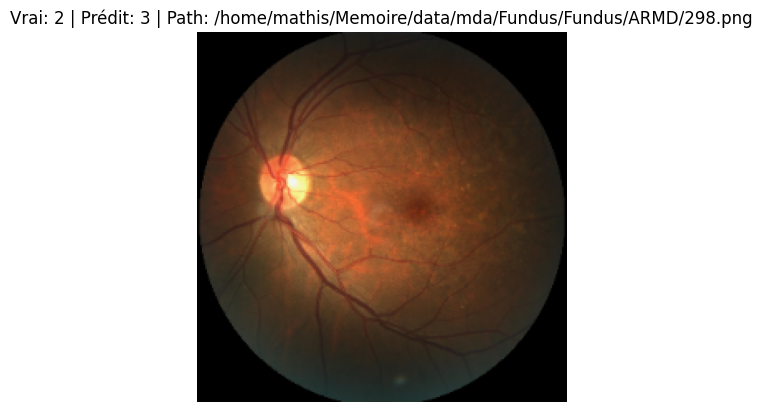

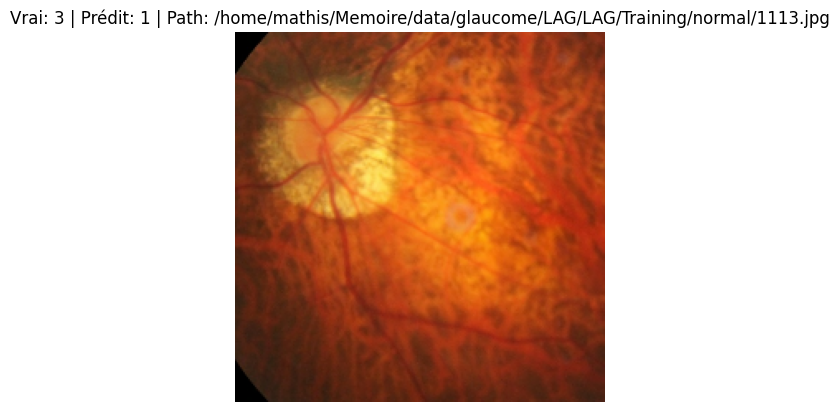

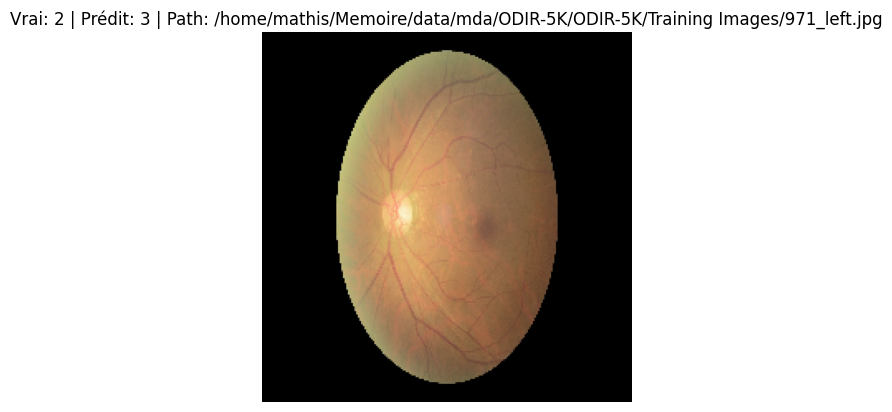

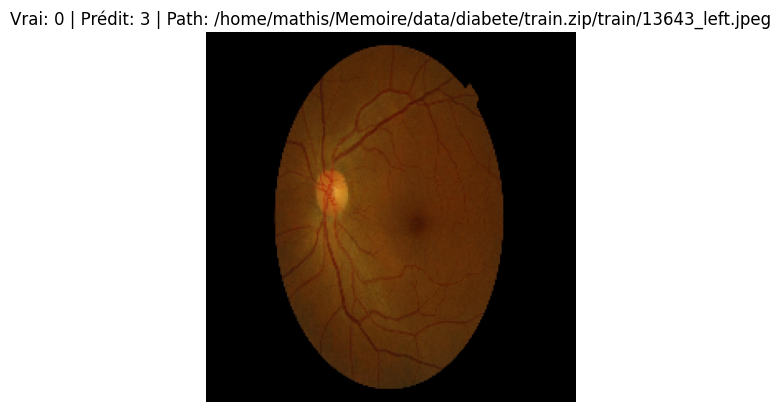

In [24]:
#montre des exemples d'images mal classées
import numpy as np
misclassified_indices = np.where(y_true != y_pred)[0]
print(f"Nombre d'images mal classées : {len(misclassified_indices)}")   
for idx in misclassified_indices[:5]:  # Affiche les 5 premières erreurs
    img_path = df_test.iloc[idx]['path']
    true_label = classes[y_true[idx]]
    pred_label = classes[y_pred[idx]]

    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [IMG, IMG])

    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Vrai: {true_label} | Prédit: {pred_label} | Path: {img_path}")
    plt.axis("off")
    plt.show()